# Track Energy

Notebook to track energy throughout the car to analyze energy discrepancies and if sensor calibration is needed

## Imports and Init

In [1]:
from data_tools.time_series import TimeSeries
from data_tools.influx_client import InfluxClient
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np

# Start and stop dates/times to query from Influx
# NOTE: TIMES SHOULD BE IN UTC
start = "2024-07-15T18:48:53Z"
stop = "2024-07-15T20:50:40Z"

# Parameters for Savitsky-Golav filter. SEE https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html#scipy.signal.savgol_filter
WINDOW_SIZE = 200
POLYNOMIAL_ORDER = 2

client = InfluxClient()

### Necessary Functions 
Functions to align **TimeSeries** objects and get signed battery current, pack power, and motor power.

In [2]:
def get_signed_battery_current(battery_current_direction: TimeSeries, battery_current: TimeSeries) -> TimeSeries:
    # Ensure that the input time series are aligned before multiplication
    battery_current_direction, battery_current = TimeSeries.align(battery_current_direction, battery_current)

    # Convert direction to be -1 or 1 for scalar multiplication
    masked_direction = np.where(battery_current_direction == 0, 1, -1)
    
    signed_current_data = masked_direction * battery_current

    # Create the metadata for the signed current TimeSeries
    signed_current_meta = {
        "start": battery_current_direction.start,
        "stop": battery_current_direction.stop,
        "car": battery_current_direction.meta["car"],
        "measurement": battery_current_direction.meta["measurement"],
        "field": "SignedBatteryCurrent",
        "granularity": battery_current_direction.granularity,
        "length": battery_current_direction.length,
        "units": "A",
    }

    # Create and return the new TimeSeries object
    signed_current = TimeSeries(signed_current_data, signed_current_meta)
    return signed_current

def get_power(current: TimeSeries, voltage: TimeSeries, new_field_name: str, units: str) -> TimeSeries:
    # Ensure that the input time series are aligned before multiplication
    current, voltage = TimeSeries.align(current, voltage)
    
    power_data = current * voltage

    # Create the metadata for the power TimeSeries
    power_meta = {
        "start": voltage.start,
        "stop": voltage.stop,
        "car": voltage.meta["car"],
        "measurement": voltage.meta["measurement"],
        "field": new_field_name,
        "granularity": voltage.granularity,
        "length": voltage.length,
        "units": units,
    }

    # Create and return the new TimeSeries object
    power = TimeSeries(power_data, power_meta)
    return power

## Setup
Query and fetch necessary data from Influx then calculate power from current and voltage, and analyze power plots from components 

In [3]:
# Battery Queries
battery_current: TimeSeries = client.query_time_series(start=start, stop=stop, field="BatteryCurrent", units="A")
battery_voltage: TimeSeries = client.query_time_series(start=start, stop=stop, field="BatteryVoltage", units="V")
battery_current_direction: TimeSeries = client.query_time_series(start=start, stop=stop, field="BatteryCurrentDirection")


# Pack Queries
pack_current: TimeSeries = client.query_time_series(start=start, stop=stop, field="PackCurrent", units="A")
pack_voltage: TimeSeries = client.query_time_series(start=start, stop=stop, field="TotalPackVoltage", units="V")


# Array/AMB queries
amb_volt1: TimeSeries = client.query_time_series(start=start, stop=stop, field="VoltSensor1", units="V")
amb_volt2: TimeSeries = client.query_time_series(start=start, stop=stop, field="VoltSensor2", units="V")
amb_curr1: TimeSeries = client.query_time_series(start=start, stop=stop, field="CurrentSensor1", units="A")
amb_curr2: TimeSeries = client.query_time_series(start=start, stop=stop, field="CurrentSensor2", units="A")

C:\Users\tamze\OneDrive\Documents\GitHub\data_analysis\.venv\Lib\site-packages\data_tools\time_series.py:298: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "car": query_df["car"][0],
C:\Users\tamze\OneDrive\Documents\GitHub\data_analysis\.venv\Lib\site-packages\data_tools\time_series.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "measurement": query_df["_measurement"][0],
C:\Users\tamze\OneDrive\Documents\GitHub\data_analysis\.venv\Lib\site-packages\data_tools\time_series.py:298: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treate

Get power from fetched data

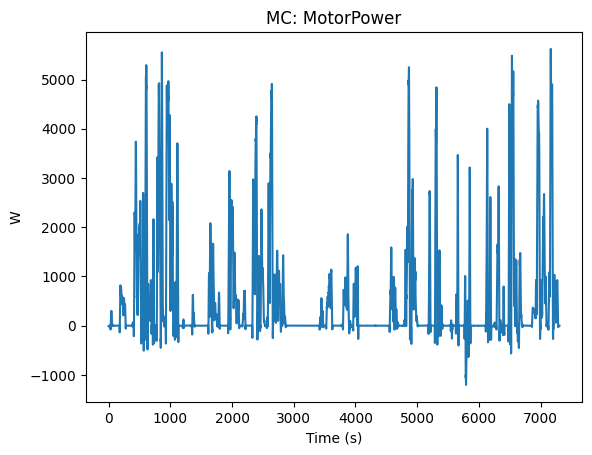

Motor Power:  [-12.37212958 -12.16074986 -11.95122105 ...   0.           0.
   0.        ]


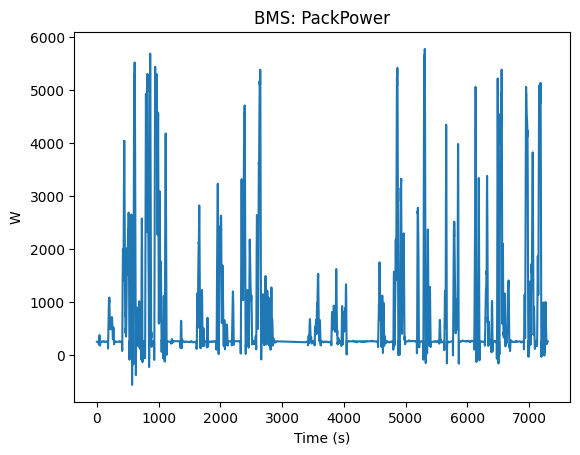

Pack Power:  [248.25686242 248.11627049 247.97740415 ... 253.1074078  253.31053842
 253.51575745]


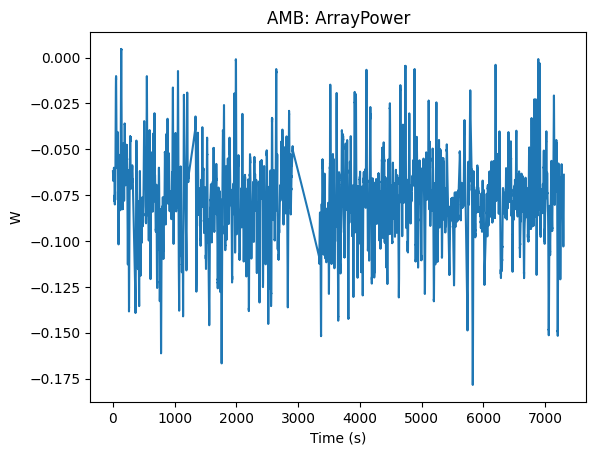

Array Power:  [-0.06199211 -0.06211919 -0.06224473 ... -0.06564721 -0.06476213
 -0.06386668]


In [4]:
# Get signed battery current
signed_current = get_signed_battery_current(battery_current_direction, battery_current)

# Get power
motor_power = get_power(signed_current, battery_voltage, "MotorPower", "W")
pack_power = get_power(pack_current, pack_voltage, "PackPower", "W")
array_power1 = get_power(amb_curr1, amb_volt1, "ArrayPower1", "W")
array_power2 = get_power(amb_curr2, amb_volt2, "ArrayPower2", "W")

# Get total power from arrays
array_power_data = array_power1 + array_power2

# Create the metadata for the power TimeSeries
array_power_meta = {
    "start": array_power1.start,
    "stop": array_power1.stop,
    "car": array_power1.meta["car"],
    "measurement": array_power1.meta["measurement"],
    "field": "ArrayPower",
    "granularity": array_power1.granularity,
    "length": array_power1.length,
    "units": array_power1.units,
}

# Create and return the new TimeSeries object
array_power = TimeSeries(array_power_data, array_power_meta)

# Clean data
motor_power = motor_power.promote(signal.savgol_filter(motor_power, WINDOW_SIZE, POLYNOMIAL_ORDER))
pack_power = pack_power.promote(signal.savgol_filter(pack_power, WINDOW_SIZE, POLYNOMIAL_ORDER))
array_power = array_power.promote(signal.savgol_filter(array_power, WINDOW_SIZE, POLYNOMIAL_ORDER))

# Visualize
motor_power.plot()
print("Motor Power: ", motor_power)
pack_power.plot()
print("Pack Power: ", pack_power)
array_power.plot()
print("Array Power: ", array_power)

## Analysis
The assumption is that **Pack Power = Motor Power - Array Power**, take the difference between *Motor Power* and *Array Power* and plot the observed discrepencies with *Pack Power*

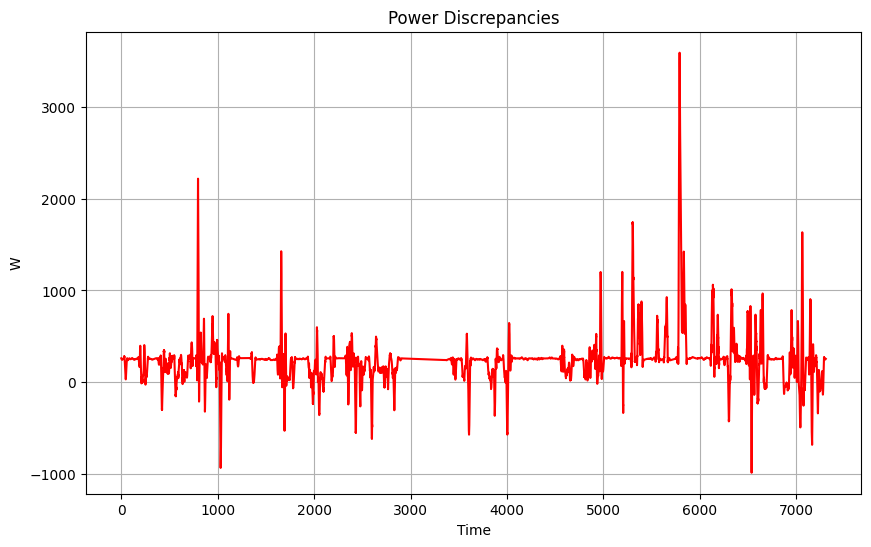

[258.92683597 258.58956131 258.25586459 ... 252.83563112 253.03749348
 253.24145457]


In [5]:
# Get the deficit in power then get the discrepancy
motor_power, array_power = TimeSeries.align(motor_power, array_power)
deficit = motor_power - array_power 

pack_power, deficit = TimeSeries.align(pack_power, deficit)
discrepancy = pack_power - deficit

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(discrepancy.x_axis, discrepancy, color='red', linestyle='-')

# Add titles and labels
plt.title('Power Discrepancies')
plt.xlabel('Time')
plt.ylabel('W')

# Add grid lines
plt.grid(True)

# Show the plot
plt.show()

print(discrepancy)

<Figure size 1000x600 with 0 Axes>

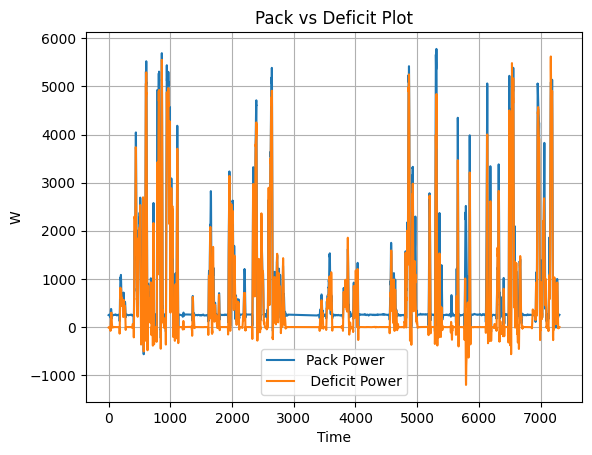

In [6]:
# Create the plot
plt.figure(figsize=(10, 6))

fig, ax = plt.subplots()
ax.plot(pack_power.x_axis, pack_power, label="Pack Power")
ax.plot(pack_power.x_axis, deficit, label=" Deficit Power")

# Add titles and labels
plt.title('Pack vs Deficit Plot')
plt.xlabel('Time')
plt.ylabel('W')

plt.grid(True)
plt.legend()

# Show the plot
plt.show()